In [1]:
import numpy as np
import xarray as xr
import dask
import xgcm
import zarr

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define face_connections for grid object
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

In [4]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r4_output/')

In [5]:
#### Monthly mean terms
grid = xgcm.Grid(main, face_connections=face_connections)

In [6]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','face','j','i')

In [7]:
# Reference salinity
Sref = 35.0

In [8]:
# Density kg/m^3
rhoconst = 1029
# m^3 to Sverdrup
Sv = 10**-6

In [9]:
# Remove oceFWflx from WVELMASS
WVELMASS = main.WVELMASS.transpose('time','face','k_l','j','i')
oceFWflx = main.oceFWflx.assign_coords(k_l=0).expand_dims('k_l').transpose('time','face','k_l','j','i')

oceFWflx = (oceFWflx/rhoconst)
WVELMASS = xr.concat([WVELMASS.sel(k_l=0) + oceFWflx, WVELMASS[:,:,1:]], 
                     dim='k_l').transpose('time','face','k_l','j','i')

In [10]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')
SALT_at_w = grid.interp(main.SALT, 'Z', boundary='extend')

In [11]:
# Freshwater advective (Eulerian+Bolus) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref
ADVr_FW = WVELMASS*main.rA*(Sref-SALT_at_w)/Sref

In [12]:
def conv3d(ADVx, ADVy, ADVr):
    
    ADVxy_diff = grid.diff_2d_vector({'X' : ADVx, 'Y' : ADVy}, boundary = 'fill')
    adv_hConv = -(ADVxy_diff['X'] + ADVxy_diff['Y'])
    adv_vConv = grid.diff(ADVr, 'Z', boundary='fill')
    
    return adv_hConv+adv_vConv

In [13]:
adv_ConvFW = conv3d(ADVx_FW,ADVy_FW,ADVr_FW)

In [14]:
forcFw = main.oceFWflx/rhoconst*main.rA

In [15]:
ds = xr.Dataset(data_vars={})

# Freshwater tendency (m^3/s)
ds['tnd'] = (grid.diff((Sref-main.SALT_snp)/Sref, 'T', boundary='fill', fill_value=0.0)*vol/main.dt)\
            .transpose('time','face','k','j','i')

# Freshwater forcing (m^3/s)
ds['frc'] = xr.concat([forcFw.reset_coords(drop=True).assign_coords(k=0).expand_dims('k')\
                       .transpose('time','face','k','j','i'),
                       xr.zeros_like(adv_ConvFW.transpose('time','face','k','j','i'))[:,:,1:]],
                      dim='k').transpose('time','face','k','j','i').where(main.hFacC==1)

# Convergence of freshwater advection (m^3/s)
ds['adv'] = adv_ConvFW.transpose('time','face','k','j','i')

# Convergence of freshwater diffusion (m^3/s)
ds['dif'] = ds['tnd'] - ds['frc'] - ds['adv']

In [16]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, j: 90, k: 50, time: 312)
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 ... 2017-12-14T12:00:00
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    CS         (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    SN         (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    rA         (face, j, i) float32 dask.array<chunksize=(1, 90, 90), meta=np.ndarray>
    PHrefC     (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Z          (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    drF        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    hFacC      (k, face, j, i) float32 dask.array<chunksize=(50, 1, 90, 90), meta=np.ndarray>
    maskC      (k, face, j, i) bool dask.array<chunksize=(50, 1, 90, 90), meta=np.ndarray>
    maskCtrlC  (k, face, j, i) bool dask.array<chunksize=(50, 1, 90, 90), meta=np.ndarray>
    dt         (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    iter       (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    tnd        (time, face, k, j, i) float64 dask.array<chunksize=(1, 1, 50, 90, 90), meta=np.ndarray>
    frc        (time, face, k, j, i) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
    adv        (time, face, k, j, i) float32 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>
    dif        (time, face, k, j, i) float64 dask.array<chunksize=(1, 1, 1, 1, 1), meta=np.ndarray>

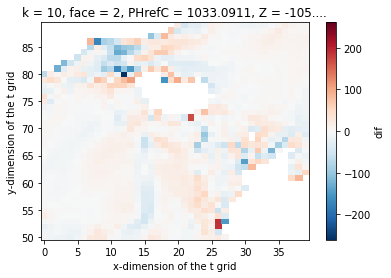

In [17]:
ds.sel(time=slice('1998-01-01','2005-12-31')).mean('time').dif[2,10,50:,:40].plot()

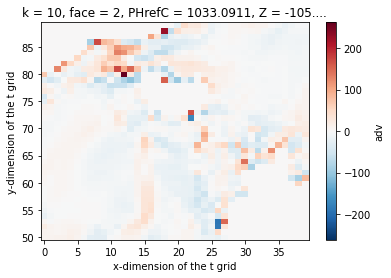

In [18]:
ds.sel(time=slice('1998-01-01','2005-12-31')).mean('time').adv[2,10,50:,:40].plot()

In [19]:
ds = ds.reset_coords(drop=True)

In [20]:
ds

,Array,Chunk
Bytes,13.14 GB,3.24 MB
Shape,"(312, 13, 50, 90, 90)","(1, 1, 50, 90, 90)"
Count,17583 Tasks,4056 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.57 GB,1.49 MB
Shape,"(312, 13, 50, 90, 90)","(1, 1, 48, 88, 88)"
Count,495602 Tasks,109512 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [21]:
for varname in ds.data_vars:
    ds[varname] = ds[varname].chunk(chunks={'time':1,'face':13,'k':50,'j':90,'i':90})

In [22]:
ds

,Array,Chunk
Bytes,13.14 GB,42.12 MB
Shape,"(312, 13, 50, 90, 90)","(1, 13, 50, 90, 90)"
Count,17895 Tasks,312 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.57 GB,21.06 MB
Shape,"(312, 13, 50, 90, 90)","(1, 13, 50, 90, 90)"
Count,495914 Tasks,312 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [23]:
compressor = zarr.Blosc(cname='zlib')
opts = {}
for varname in ds.data_vars:
    opts[varname] = {'compressor': compressor, 'chunks': (1, 13, 50, 90, 90)}

In [24]:
from dask.diagnostics import ProgressBar

In [25]:
ls /mnt/efs/data/ecco/

budg_anom/                             ecco_section_transports_fw_Sref351.nc
ecco_budg_anom_fw.nc                   ecco_section_transports_fw_Sref352.nc
ecco_budg_anom_heat.nc                 ecco_section_transports_fw_eulerian.nc
ecco_budg_anom_sln.nc                  ecco_section_transports_heat.nc
ecco_budg_fw.nc                        ecco_section_transports_slt.nc
ecco_budg_fw_Sref300.nc                ecco_section_transports_slt_adv.nc
ecco_budg_fw_oceFW.nc                  eccov4_spna_fw_flx.csv
ecco_budg_heat.nc                      eccov4_spna_heat_flx.csv
ecco_budg_oceFW.nc                     eccov4r4/
ecco_budg_sln.nc                       eccov4r4_interp_salt.nc
ecco_budg_slt.nc                       eccov4r4_lfwc_nsea_monthly.nc
ecco_budg_vol.nc                       eccov4r4_lfwc_nsea_monthly_anom.nc
ecco_dz.nc                             eccov4r4_lfwc_nsea_pentad.nc
ecco_interp_area.nc                    eccov4r4_lfwc_spna_monthly.nc
ecco_lfwc_spna_monthly.nc          

In [26]:
with ProgressBar():
    ds.to_zarr('/mnt/efs/data/ecco/zarr/eccov4r4_budgFw', encoding=opts)

[########################################] | 100% Completed | 11min 17.3s
